# MIDI Analysis

We use this data to build a logistic regression model to compare two composers, namely Hans Newsidler and Francesco da Milano.

In [1]:
import numpy as np
import pandas as pd

# for navigating directories
import os

# statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pingouin as pg

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# loading files
import json

# Preparations for Exporting Plots

In [2]:
def export_and_plot(fig, file_name, width=585):
    path = os.path.join('plots', f'{file_name}.json')
    json_data = fig.to_json()
    with open(path, 'w') as f:
            f.write(json_data)

    fig.update_layout(width=width)
    fig.show()

In [3]:
# load main dataset
wd = os.getcwd()
lute_data_path = os.path.join(wd, 'data', 'data_sets', 'lute_data.csv')
lute_df = pd.read_csv(lute_data_path, dtype={'Volume': str})
lute_df['Date'] = lute_df['Date'].str.replace('[^0-9]','', regex=True).astype(int)

We subset our data to contain only pieces for solo renaissance-lute. We print a list of composers for whom we have many pieces.

In [4]:
ren_lute_instruments = ['10-course', '9-course', '8-course', '7-course', '6-course']
solo_ren_lute_df = lute_df.query('Ensemble in @ren_lute_instruments').copy()
solo_ren_lute_df.Composer.value_counts().head(8)

Composer
Anonymous              4016
John Dowland            421
Elias Mertel            374
Francesco da Milano     349
Hans Newsidler          345
Vincenzo Galilei        306
Nicolas Vallet          305
Matth?us Waissel        264
Name: count, dtype: int64

For our regression model, we decide to go with Hans Newsidler and Francesco da Milano as already mentioned above.

In [5]:
df_composer = solo_ren_lute_df.query('Composer in ("Hans Newsidler", "Francesco da Milano")').copy()
df_composer.Composer.value_counts()

Composer
Francesco da Milano    349
Hans Newsidler         345
Name: count, dtype: int64

# Getting the Data

In [6]:
# import range feature data and merge with main dataset
feature_path = os.path.join(wd, 'data', 'data_sets', 'extracted_feature_values_range.csv')
range_feature_data = pd.read_csv(feature_path, index_col='index')
solo_ren_lute_df_range = solo_ren_lute_df.merge(range_feature_data, how='left', left_index=True, right_index=True)

In [7]:
# load feature data
feature_data_path = os.path.join(wd, 'data', 'data_sets', 'extracted_feature_values.csv')
feature_data = pd.read_csv(feature_data_path)

feature_data['index'] = feature_data['Unnamed: 0'].str.extract(r'(\d+)').astype(int)
feature_data = feature_data.drop(columns='Unnamed: 0')
feature_data = feature_data.set_index('index')

# merge with main dataset
df_composer = df_composer.merge(feature_data, how='left', left_index=True, right_index=True)
df_composer = df_composer.dropna(subset=['Number_of_Pitches']) # defective MIDIs or extraction failure
df_composer = df_composer.query('Number_of_Pitched_Instruments == 1') # only keep solo pieces
df_composer = df_composer.rename(columns={'Non-Standard_Chords':'Non_Standard_Chords'})

# encode Francesco da Milano as 1, and the rest (Hans Newsidler) as 0
df_composer['encoding'] = np.where(df_composer['Composer'] == 'Francesco da Milano', 1, 0)

# Check Example: Range

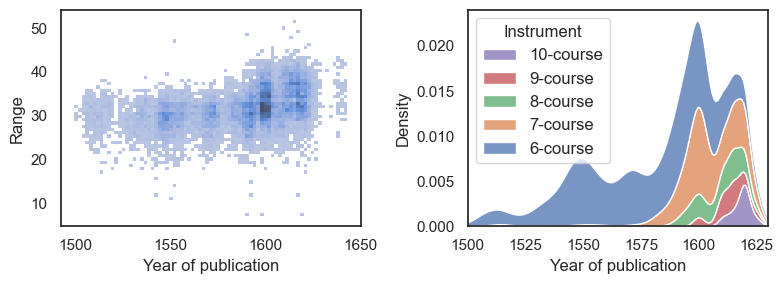

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

data_scatterplot = solo_ren_lute_df_range.query('Date > 1480 and Date < 1650 and Range < 70 and Range > 0').copy()
data_scatterplot['Date'] = data_scatterplot['Date'] + np.random.uniform(-3, 3, size=len(data_scatterplot))
data_scatterplot['Range'] = data_scatterplot['Range'] + np.random.uniform(-2, 2, size=len(data_scatterplot))

sns.histplot(data=data_scatterplot, x='Date', y='Range', bins=(75,60), ax=axs[0])

axs[0].set_xlabel('Year of publication')

sns.kdeplot(
    x='Date',
    data=solo_ren_lute_df.query("Date > 1480 and Date < 1650"),
    fill=True,
    hue='Ensemble',
    multiple='stack',
    bw_adjust=1.2,
    ax=axs[1]
)

legend_labels = ['10-course', '9-course', '8-course', '7-course', '6-course']
legend = axs[1].legend(
    labels=legend_labels,
    fontsize='medium',
    loc='upper left',
    title='Instrument'
)
legend.get_title().set_fontsize('medium')
axs[1].set_xlim(1500, 1630)
axs[1].set_xlabel('Year of publication')

plt.tight_layout()
plt.show()

In [97]:
data_scatterplot = solo_ren_lute_df_range.copy()
# both variables are discrete and pieces are clustered around publication dates of documents: add some jitter to make the pattern more visible
seed = 2
rng = np.random.RandomState(seed)
data_scatterplot['Date'] = data_scatterplot['Date'] + rng.uniform(-2.5, 2.5, size=len(data_scatterplot))
data_scatterplot['Range'] = data_scatterplot['Range'] + rng.uniform(-1, 1, size=len(data_scatterplot))
data_scatterplot = data_scatterplot.sample(8000, random_state=seed)

# scatterplot: range vs date grouped by type of instrument
fig = px.scatter(
    data_scatterplot,
    x="Date",
    y="Range",
    color='Ensemble',
    category_orders={'Ensemble': ['6-course', '7-course', '8-course', '9-course', '10-course']},
    labels={'Ensemble':'Instrument'},
    hover_data={'Ensemble':True, 'Range':False, 'Date':False},
    opacity=0.6
)


# general layout
fig.update_layout(
    title=dict(text='Range and Instrument Over Time', font=dict(size=25)),
    margin=dict(l=0,r=0,b=0,t=50),
    template='simple_white',
    height=380,
    legend=dict(x=1, y=1, xanchor='left', yanchor='top', font=dict(size=10)),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes(range=(1490,1660))
fig.update_yaxes(range=(3,55))

export_and_plot(fig, 'range_year_scatterplot', width=585)

# Data Cleaning

Since our task is explanatory rather than predictive, we should only consider features that we can actually understand. For example, if we can distinguish between composers by looking at the pitch histograms of their pieces, we don't really learn anything about their compositional styles. Therefore, we create a list of high-level features that are easy to interpret. 

We look at the distributions of the selected features to spot potential irregularities.

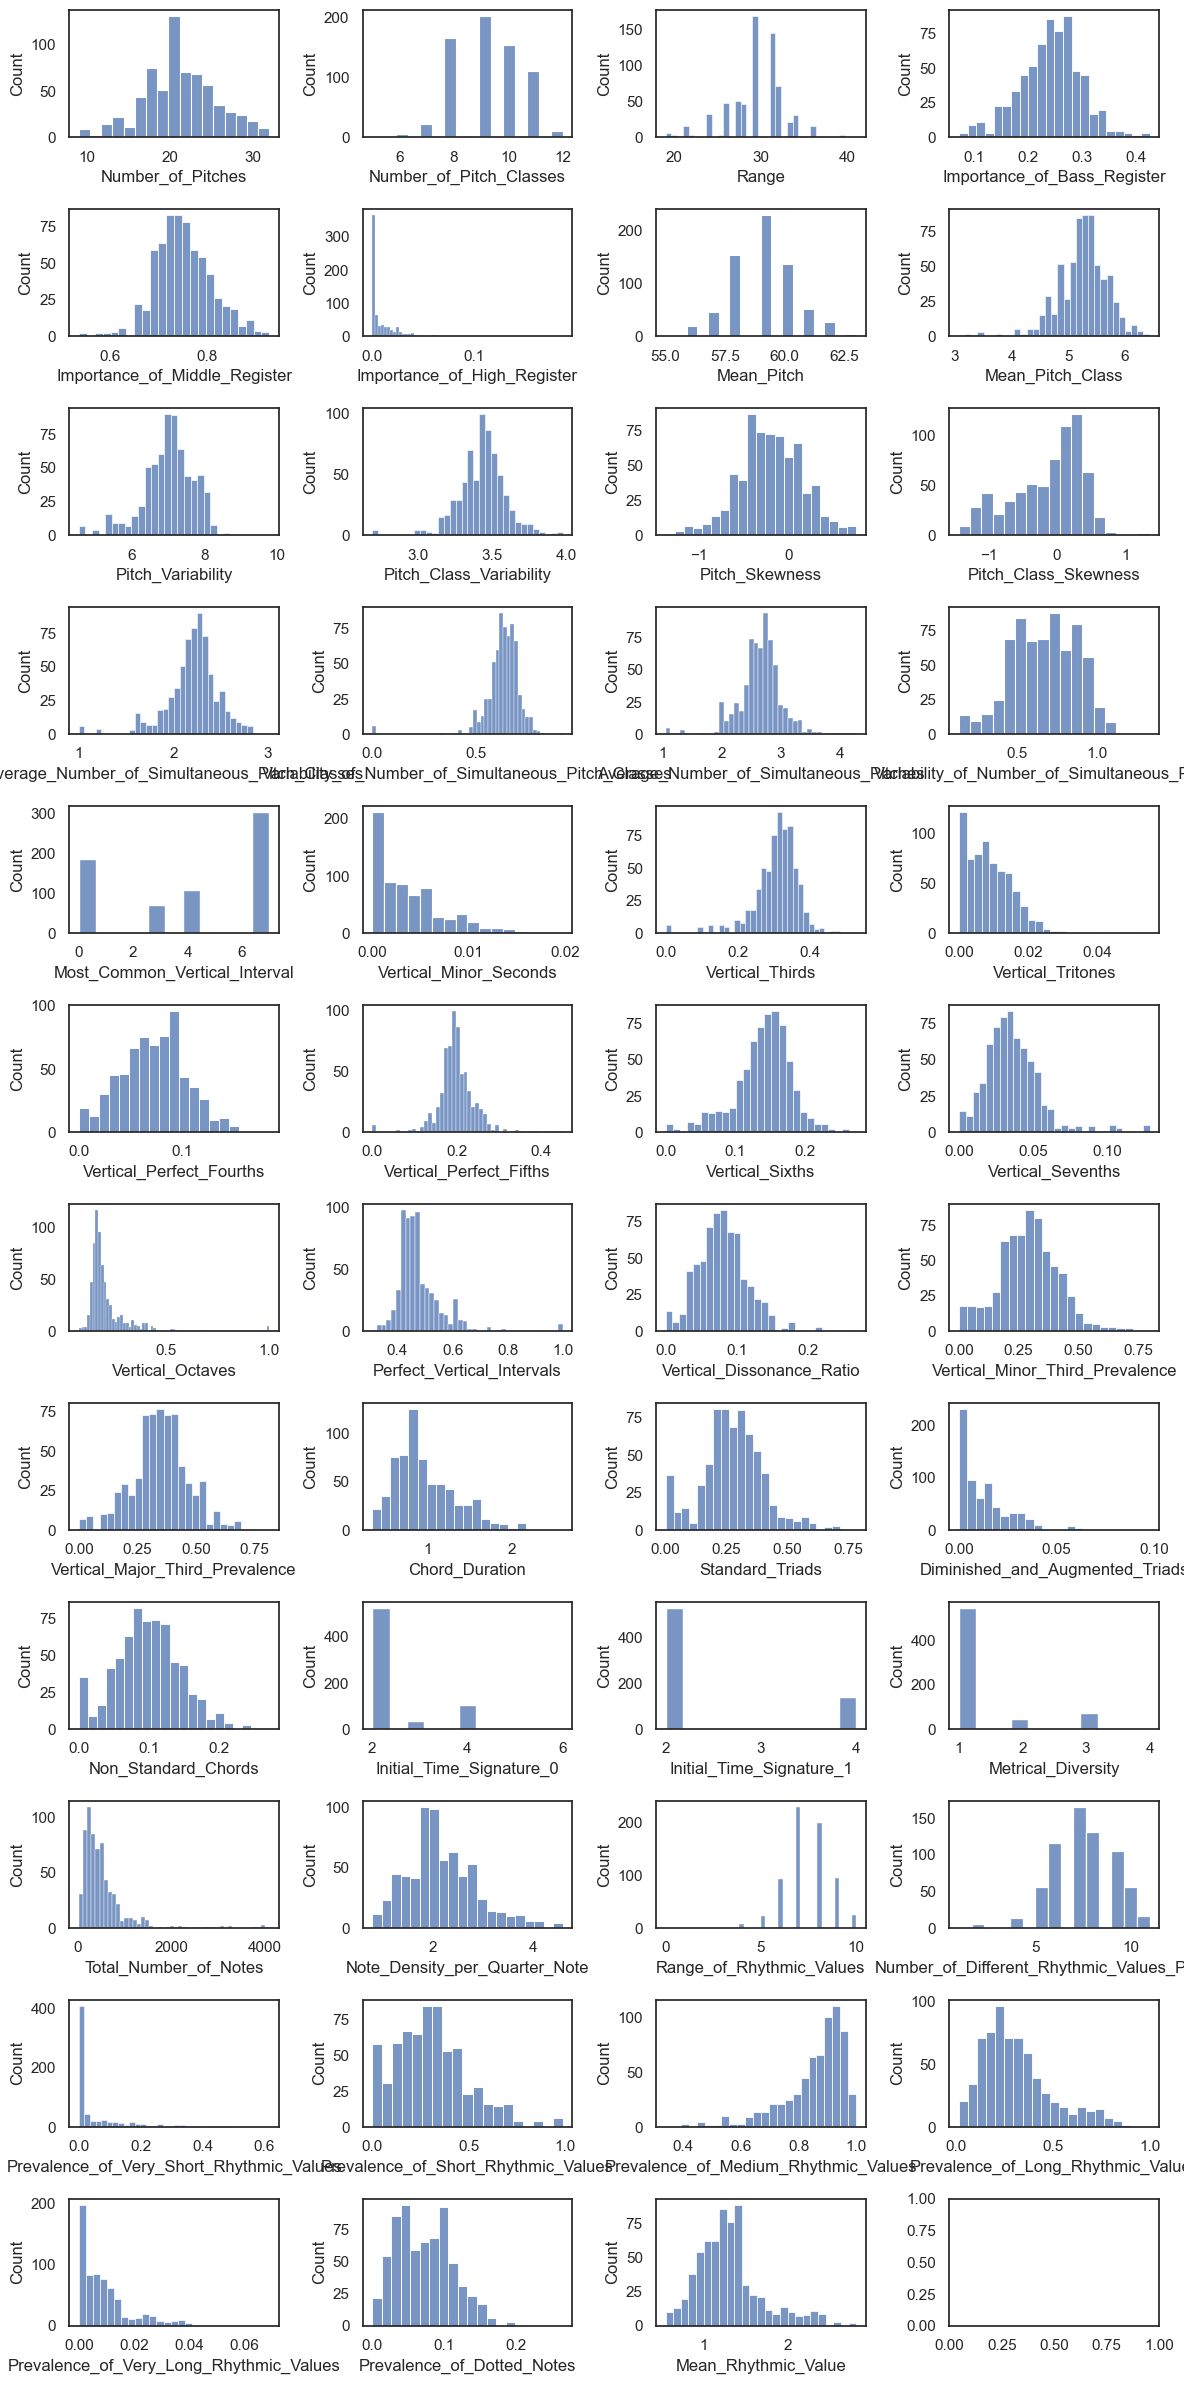

In [18]:
# get columns in our dataframe that contain MIDI features
feature_list = list(df_composer.columns)[30:77]

# plot distributions of all our features
total = len(feature_list)
cols = 4
rows = int(np.ceil(total / cols))

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 2*rows))
i = 0
for row in axes:
    for ax in row:
        sns.histplot(data=df_composer, x=feature_list[i], legend=False, ax=ax)
        ax.set
        i += 1
        if i == len(feature_list):
            break
            
plt.tight_layout()
plt.show()

In [19]:
# drop exercises and pieces for which the Importance_of_High_Register variable is greater than or equal to 0.06
df_composer = df_composer.query(
    'Type != "exercise" '
    ' and Importance_of_High_Register < 0.06'
)

# Example: Feature

As a quick check, we plot two features and compare their distributions for da Milano and Newsidler.

In [20]:
# histogram of Importance_of_Bass_Register: da Milano vs. Newsidler
fig = px.histogram(
    df_composer,
    x='Importance_of_Bass_Register',
    color='Composer',
    barmode='overlay',
    category_orders={'Composer':['Hans Newsidler', 'Francesco da Milano']},
    color_discrete_sequence=["#7eb0d5", "#fd7f6f"],
    opacity=0.6
)

# layout
fig.update_layout(
    margin=dict(l=0,r=0,b=0,t=0),
    height=300,
    legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top'),
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks='outside')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', showgrid=False)

export_and_plot(fig, 'bass_register_histogram', width=300)

In [21]:
# histogram of Vertical_Tritones: da Milano vs. Newsidler
fig = px.histogram(
    df_composer,
    x='Vertical_Tritones',
    color='Composer',
    barmode='overlay',
    category_orders={'Composer':['Hans Newsidler', 'Francesco da Milano']},
    color_discrete_sequence=["#7eb0d5", "#fd7f6f"],
    opacity=0.6
)

# annotation for outlier piece
fig.add_annotation(
    text="Ein gut Preambel",
    x=0.055,
    y=2,
    ax=-50,
    ay=-50,
    arrowhead=3,
    arrowsize=2,
    arrowwidth=1,
    arrowcolor='#303030',
    font=dict(size=12, color="#303030"),
    bordercolor="#303030",
    borderwidth=1.5,
    borderpad=4,
    bgcolor='white',
    opacity=0.9
)

# layout
fig.update_layout(
    margin=dict(l=0,r=0,b=0,t=0),
    height=300,
    legend=dict(x=0.02, y=0.98, xanchor='left', yanchor='top'),
)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks='outside')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', showgrid=False)

export_and_plot(fig, 'tritones_histogram', width=300)

In numbers:

In [22]:
# Filter data for each composer
newsidler = df_composer[df_composer['Composer'] == 'Hans Newsidler']
milano = df_composer[df_composer['Composer'] == 'Francesco da Milano']

# Create subplots
fig = make_subplots(rows=1, cols=2)

# Add histogram for Importance_of_Bass_Register for both composers
fig.add_trace(go.Histogram(
    x=newsidler['Importance_of_Bass_Register'],
    name='Hans Newsidler',
    opacity=0.7,
    marker_color='#7eb0d5',
    xbins=dict(size=0.01),
    showlegend=False
), row=1, col=1)

fig.add_trace(go.Histogram(
    x=milano['Importance_of_Bass_Register'],
    name='Francesco da Milano',
    opacity=0.7,
    marker_color='#fd7f6f',
    xbins=dict(size=0.01),
    showlegend=False
), row=1, col=1)

# Add histogram for Vertical_Tritones for both composers
fig.add_trace(go.Histogram(
    x=newsidler['Vertical_Tritones'],
    name='Hans Newsidler',
    opacity=0.7,
    marker_color='#7eb0d5',
    xbins=dict(size=0.002)
), row=1, col=2)

fig.add_trace(go.Histogram(
    x=milano['Vertical_Tritones'],
    name='Francesco da Milano',
    opacity=0.7,
    marker_color='#fd7f6f',
    xbins=dict(size=0.002)
), row=1, col=2)

# Add annotation for outlier piece in the second histogram
fig.add_annotation(
    text="Ein gut Preambel",
    x=0.055,
    y=2,
    ax=-50,
    ay=-50,
    arrowhead=3,
    arrowsize=2,
    arrowwidth=1,
    arrowcolor='#303030',
    font=dict(size=12, color="#303030"),
    bordercolor="#303030",
    borderwidth=1.5,
    borderpad=4,
    bgcolor='white',
    opacity=0.9,
    xref="x2",
    yref="y2"
)

# Update layout for the combined figure
fig.update_layout(
    title=dict(text='Musical Features by Composer', font=dict(size=25)),
    margin=dict(l=0,r=0,b=0,t=50),
    barmode='overlay',
    height=350,
    legend=dict(x=0.98, y=0.98, xanchor='right', yanchor='top'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

# Update axes for both subplots
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', title='Importance of Bass Register', row=1, col=1)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', showgrid=False, row=1, col=1)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', title='Vertical Tritones', row=1, col=2)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', ticks='outside', showgrid=False, row=1, col=2)

export_and_plot(fig, 'musical_features_by_comp')


In [26]:
pd.pivot_table(
    data=df_composer,
    values=['Vertical_Tritones', 'Importance_of_Bass_Register'],
    columns=['Composer'],
    aggfunc=['mean', 'std']
).round(3)

mean                 \
Composer                    Francesco da Milano Hans Newsidler   
Importance_of_Bass_Register               0.241          0.237   
Vertical_Tritones                         0.012          0.006   

                                            std                 
Composer                    Francesco da Milano Hans Newsidler  
Importance_of_Bass_Register               0.048          0.064  
Vertical_Tritones                         0.005          0.007

# Numerical Features

### Linear Relationship with Log Odds

In [184]:
def plot_log_odds(feature, ax):
    """
    Plot the log odds da Milano vs. Newsidler against values of specified feature.
    """
    # Calculate the 1/3 and 2/3 quantiles for the specified feature
    quantiles = df_composer[feature].quantile([1/3, 2/3]).to_numpy()

    # Segment the dataframe into three ranges based on the quantiles
    r1 = df_composer.query(f"{feature} < @quantiles[0]")
    r2 = df_composer.query(f"{feature} >= @quantiles[0] & {feature} < @quantiles[1]")
    r3 = df_composer.query(f"{feature} >= @quantiles[1]")
    rs = [r1, r2, r3]
    
    # calculate the mean / probability of da Milano (1) vs. Newsidler (0) for each quantile
    ps = [x.encoding.mean() for x in rs]
    # from probabilities to log odds
    log_odds = [np.log(x/(1-x)) for x in ps]

    # calculate the median value of the specified feature for each quantile
    medians = [x[feature].median() for x in rs]

    # scatter plot of median vs. log odds
    sns.scatterplot(x=medians, y=log_odds, s=60, ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('feature values')
    ax.set_ylabel('log odds')

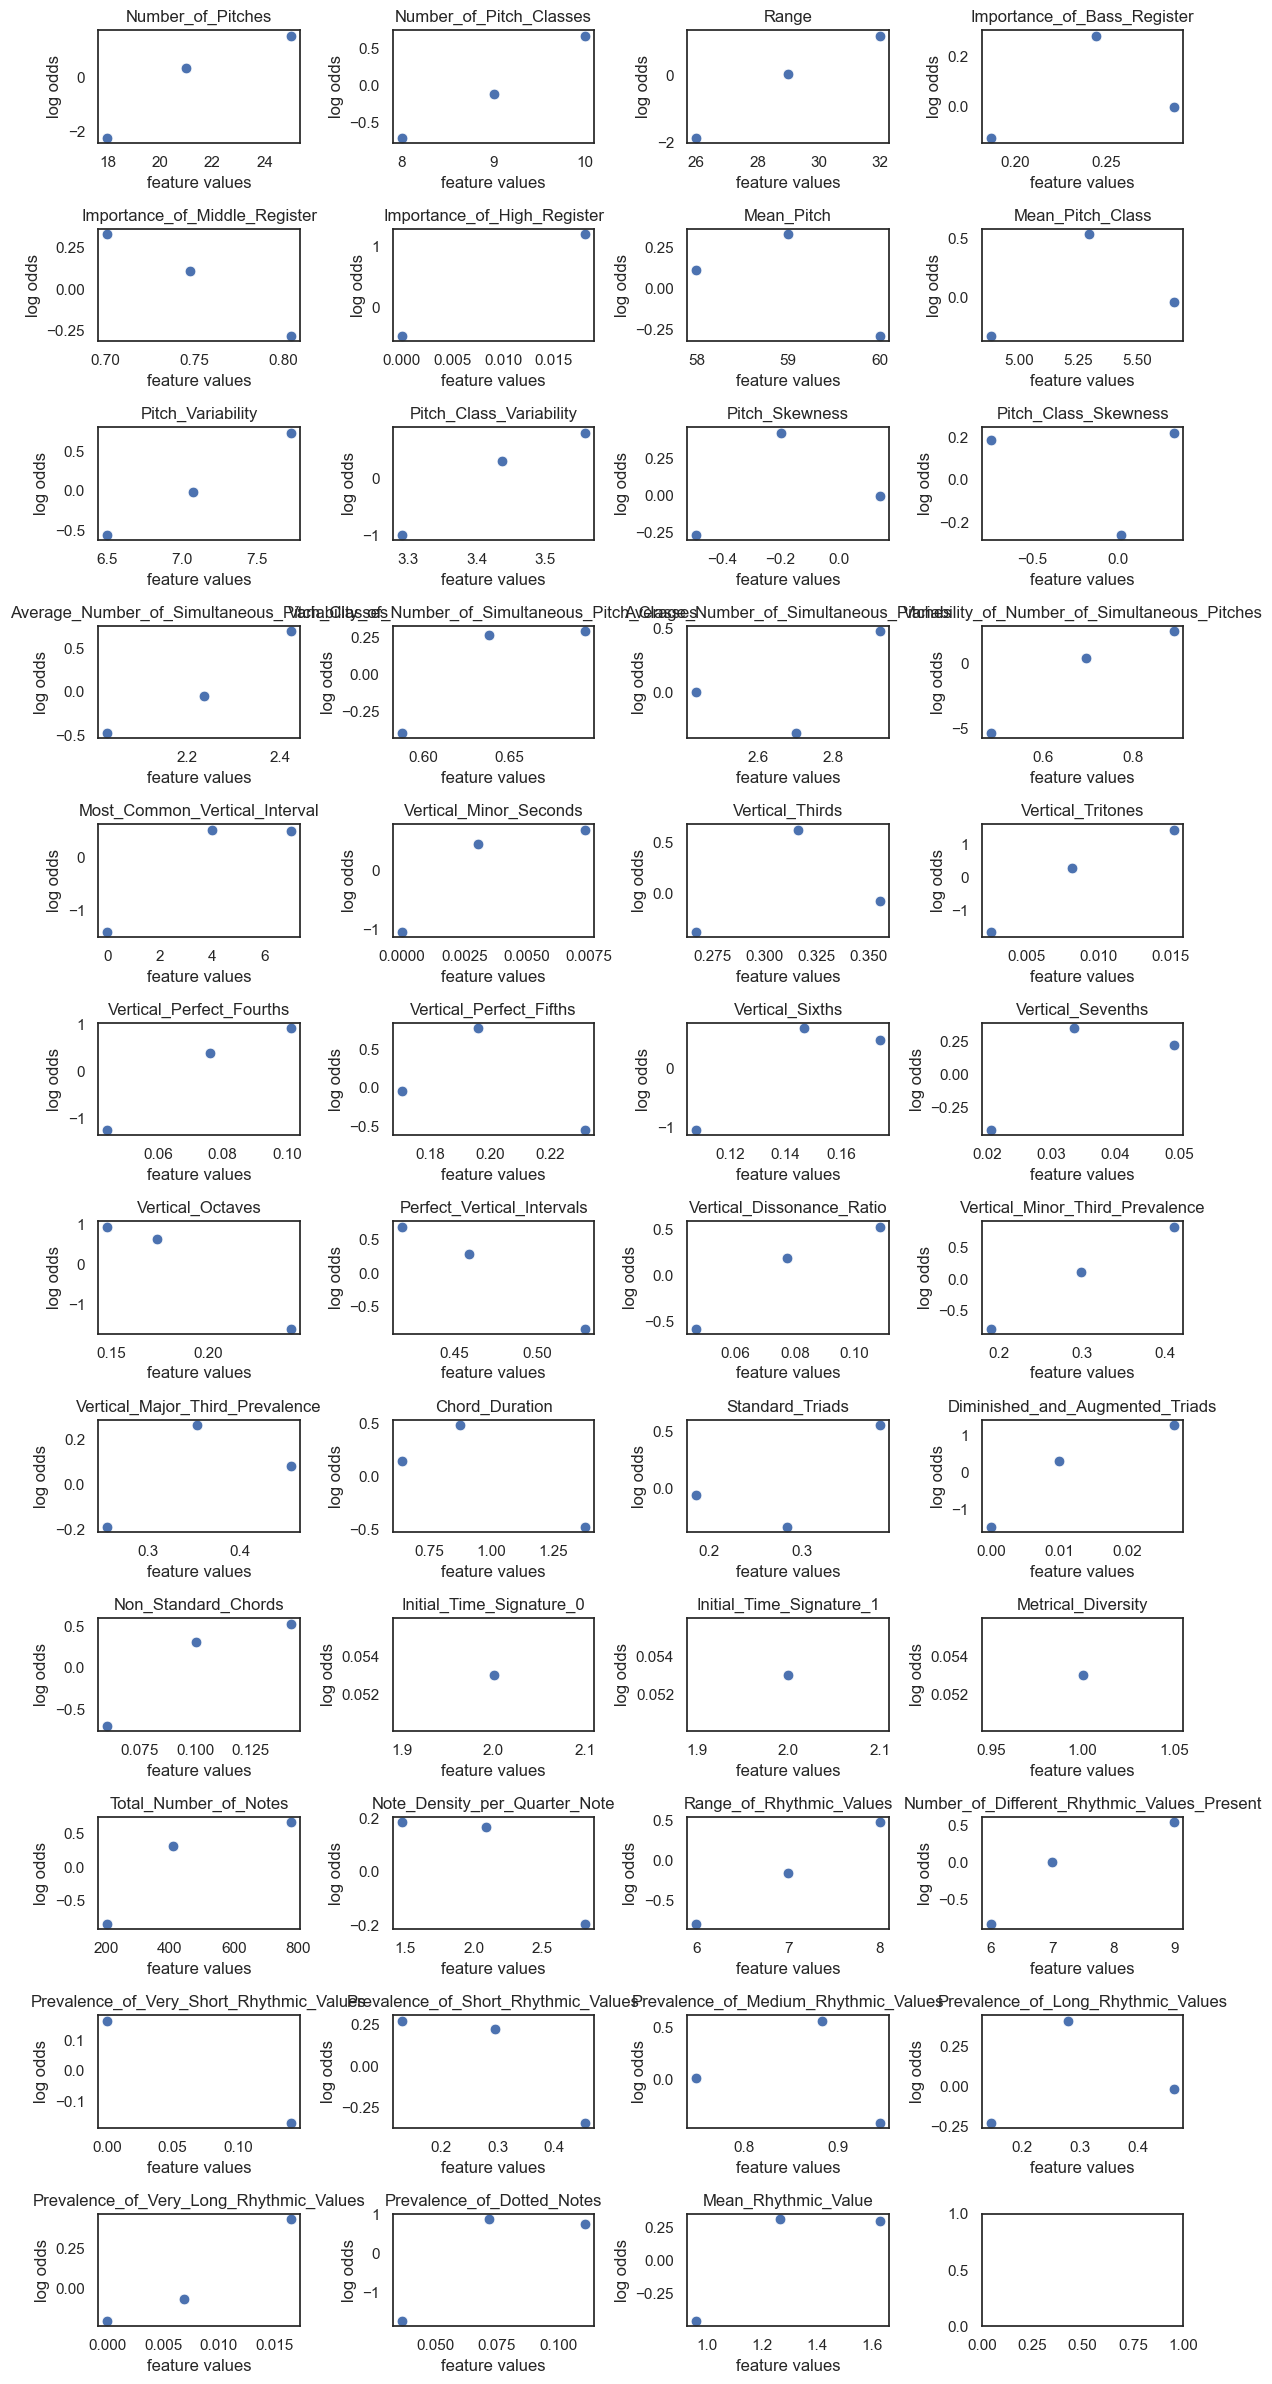

In [185]:
# plot relationship between features and log odds to check for non linearity
total = len(feature_list)
cols = 4
rows = int(np.ceil(total / cols))

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 2*rows))
i = 0
for row in axes:
    for ax in row:
        plot_log_odds(feature_list[i], ax)
        i += 1
        if i == len(feature_list):
            break
            
plt.tight_layout()
plt.show()

In [186]:
selected_features = [
    'Number_of_Pitches',
    'Number_of_Pitch_Classes',
    'Range',
    'Pitch_Variability',
    'Pitch_Class_Variability',
    'Average_Number_of_Simultaneous_Pitch_Classes',
    'Variability_of_Number_of_Simultaneous_Pitches',
    'Vertical_Tritones',
    'Vertical_Perfect_Fourths',
    'Vertical_Octaves',
    'Perfect_Vertical_Intervals',
    'Vertical_Dissonance_Ratio',
    'Vertical_Minor_Third_Prevalence',
    'Metrical_Diversity',
    'Note_Density_per_Quarter_Note',
    'Range_of_Rhythmic_Values',
    'Number_of_Different_Rhythmic_Values_Present',
    'Prevalence_of_Long_Rhythmic_Values',
    'Prevalence_of_Very_Long_Rhythmic_Values'
]

### Collinearity 

Before we build the model, we quickly plot a correlation matrix of our variables, so we can avoid having two highly correlated features in our regression model. But it looks like we don't have to worry here. This is probably due to our selection procedure. If we have two highly correlated features both of which are important, Lasso will shrink one and keep the other. If we had, for instance, excluded the Range variable before the procedure, it is possible that the Importance_of_High_Register feature would have come out as very important.

In [187]:
selected_features = [
    'Number_of_Pitch_Classes',
    'Range',
    'Average_Number_of_Simultaneous_Pitch_Classes',
    'Vertical_Tritones',
    'Vertical_Octaves',
    'Note_Density_per_Quarter_Note',
    'Number_of_Different_Rhythmic_Values_Present'
]

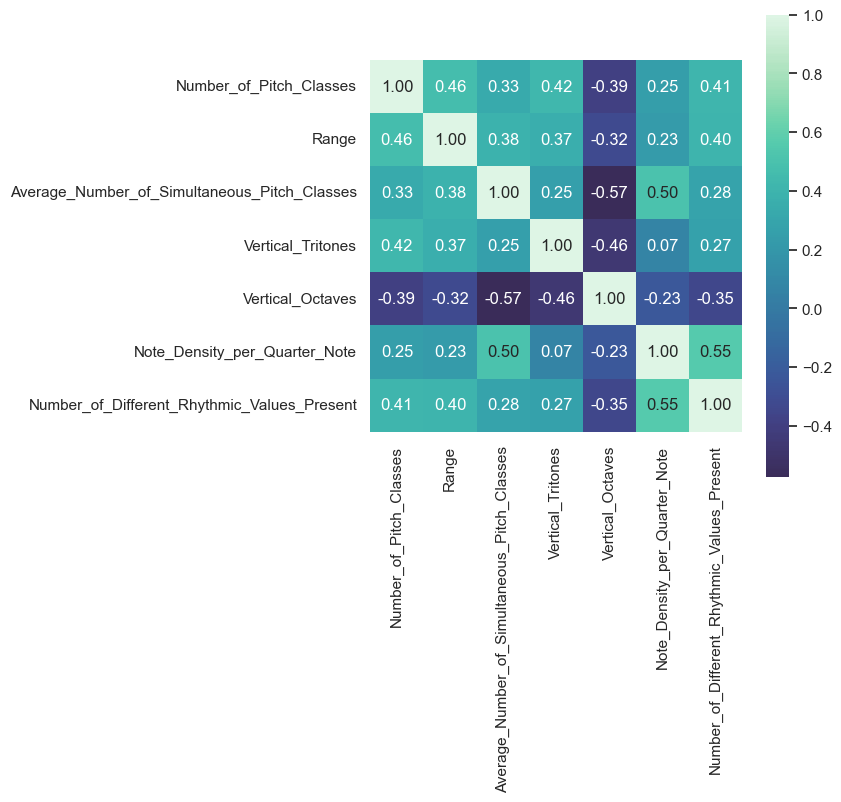

In [188]:
fig = plt.figure(figsize=(6,6))

matrix = df_composer[selected_features].corr()
sns.heatmap(matrix, center=0, annot=True, fmt='.2f', square=True, cmap='mako')

plt.show()

In [189]:
df_num = df_composer[selected_features]
df_num = add_constant(df_num)

def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return(vif)

calc_vif(df_num)

,variables,VIF
0,const,317.428761
1,Number_of_Pitch_Classes,1.541934
2,Range,1.518529
3,Average_Number_of_Simultaneous_Pitch_Classes,2.125443
4,Vertical_Tritones,1.460175
5,Vertical_Octaves,1.907477
6,Note_Density_per_Quarter_Note,1.940243
7,Number_of_Different_Rhythmic_Values_Present,1.887705


# Categorical Features

In [190]:
df_composer['Time_Signature_Change'] = df_composer['Metrical_Diversity'].apply(lambda x: 0 if x == 1 else 1)

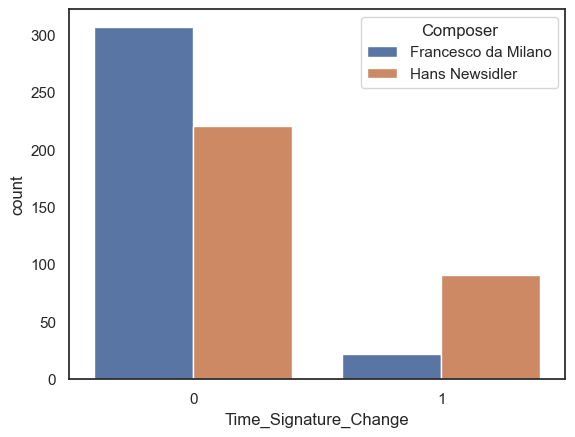

In [191]:
sns.countplot(data=df_composer, x='Time_Signature_Change', hue='Composer')
plt.show()

# Regression Results

We can finally build our model. Before we do so, we scale some of the features to make the model coefficients more interpretable. In particular, we turn features measured as fractions into percent.

In [192]:
final_features = [
    'Number_of_Pitch_Classes',
    'Range',
    'Vertical_Tritones',
    'Note_Density_per_Quarter_Note',
    'Number_of_Different_Rhythmic_Values_Present',
    'Time_Signature_Change'
]

In [193]:
df_composer_scaled = df_composer[final_features].copy()

# scale features
for col in ['Vertical_Tritones']:
    df_composer_scaled[col] = df_composer_scaled[col] * 100

# prepare data; da Milano is coded as 1, Newsidler as 0 
X = df_composer_scaled
y = df_composer['encoding']

In [194]:
lom = pg.logistic_regression(X, y, penalty=None)

lom['odds ratio'] = np.exp(lom['coef'])
lom['odds ratio ci low'] = np.exp(lom['CI[2.5%]'])
lom['odds ratio ci high'] = np.exp(lom['CI[97.5%]'])
lom['odds ratio ci low diff'] = lom['odds ratio'] - lom['odds ratio ci low']
lom['odds ratio ci high diff'] = lom['odds ratio ci high'] - lom['odds ratio']
lom['names'] = ['Intercept'] + final_features
lom = lom.round(2)
lom['names'] = lom['names'].str.replace('_', ' ')
lom = lom.iloc[1:,:]
lom

,names,coef,se,z,pval,CI[2.5%],CI[97.5%],odds ratio,odds ratio ci low,odds ratio ci high,odds ratio ci low diff,odds ratio ci high diff
1,Number of Pitch Classes,0.13,0.11,1.12,0.26,-0.10,0.35,1.14,0.91,1.42,0.23,0.29
2,Range,0.57,0.06,9.69,0.00,0.45,0.68,1.77,1.57,1.98,0.19,0.22
3,Vertical Tritones,1.12,0.20,5.55,0.00,0.73,1.52,3.07,2.07,4.56,1.00,1.49
4,Note Density per Quarter Note,-1.37,0.21,-6.39,0.00,-1.79,-0.95,0.25,0.17,0.39,0.09,0.13
5,Number of Different Rhythmic Values Present,0.27,0.10,2.66,0.01,0.07,0.46,1.30,1.07,1.59,0.23,0.28
6,Time Signature Change,-2.31,0.36,-6.46,0.00,-3.01,-1.61,0.10,0.05,0.20,0.05,0.10


In [206]:
# plot regression coefficients as odds ratios
fig = go.Figure()

odds = lom['odds ratio']
names = lom['names'].replace({'Number of Different Rhythmic Values Present':'Different Rhythmic Values', 'Note Density per Quarter Note':'Note Density per Quarter'})
colors = ['#7eb0d5' if x < 1 else 'lightgrey' if x < 1.2 else '#fd7f6f' for x in odds]
errors_low = lom['odds ratio ci low diff']
errors_high = lom['odds ratio ci high diff']
          
for odd, name, error_low, error_high, color in zip(odds, names, errors_low, errors_high, colors):
    fig.add_trace(go.Scatter(
        x=[odd],
        y=[name],
        error_x=dict(
            type='data',
            symmetric=False,
            array=[error_high],
            arrayminus=[error_low],
            color=color,
            thickness=2
        ),
        mode='markers',
        marker=dict(size=10, symbol='diamond', color=color),
        name=''
    ))

# add vertical line at odds = 1 (null hypothesis)
fig.add_shape(go.layout.Shape(
    type="line",
    x0=1,
    x1=1,
    y0='Number of Pitch Classes',
    y1='Time Signature Change',
    line=dict(color='black', width=2, dash='dash')
))

# layout
fig.update_layout(
    title=dict(text='Regression Results', font=dict(size=25)),
    margin=dict(l=0,r=0,b=0,t=50),
    height=320,
    template='simple_white',
    showlegend=False,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
fig.update_xaxes(type="log")

export_and_plot(fig, 'regression_results', width=585)

The fact that the exponentiated coefficient is less than 1 indicates that time signature changes are more characteristic of Hans Newsidler's music. Specifically, for each occurrence of a time signature change in a composition, the odds that the piece was composed by Francesco da Milano decrease by a factor of 0.1. Da Milano's pieces, on the other hand, tend to have a greater number of unique rythmic values. Keeping other factors constant, one additional unique rythmic value increases the odds that a piece belongs to Milano's compositions by 30%

In [56]:
import statsmodels.api as sm

logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.396329
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               encoding   No. Observations:                  641
Model:                          Logit   Df Residuals:                      634
Method:                           MLE   Df Model:                            6
Date:                Thu, 04 Jul 2024   Pseudo R-squ.:                  0.4279
Time:                        01:26:25   Log-Likelihood:                -254.05
converged:                       True   LL-Null:                       -444.08
Covariance Type:            nonrobust   LLR p-value:                 5.371e-79
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                         -17.5107      1.780     -9.840      0.000     -20.999     -14.023
Number_of_Pitch_Classes                         0.1288      0.115      1.123      0.261      -0.096       0.353
Range                                           0.5693      0.059      9.690      0.000       0.454       0.684
Vertical_Tritones                               1.1213      0.202      5.549      0.000       0.725       1.517
Note_Density_per_Quarter_Note                  -1.3701      0.214     -6.388      0.000      -1.790      -0.950
Number_of_Different_Rhythmic_Values_Present     0.2657      0.100      2.657      0.008       0.070       0.462
Time_Signature_Change                          -2.3118      0.358     -6.465      0.000      -3.013      -1.611
===============================================================================================================
"""